# Analysis of Results

This file contains a variety of analyses of the models and data generated from the `save_models_*` files.

The tests run are:
- Which subject(s) have the most influence on MAE (general models)
- Which features are the most important (general/individual)?
- Graphing all of the different model types for general/individual/sensors

In [1]:
# Importing necessary libraries
from pycaret.datasets import get_data
from pycaret.regression import *
import seaborn as sns
import ast
import os
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt

### DataFrame Naming Style
In this `.ipynb` file, all DataFrames were named in the following format to keep variable names short and concise:
- df_{type}_{general/individual}
Examples: 
- The general dataframe for the testing results has the name: `df_t_g` (t = test, g = general)
- The feature importance dataframe for the individual results has the name: `df_fi_i` (fi = feature importance, i = individual)

In [2]:
%%capture
# Loading all of the necessary DataFrames
df_fi_g = get_data('outputs/general/feature_importance_general')
df_fi_i = get_data('outputs/individual/feature_importance_individual')
df_t_g = get_data('outputs/general/test_general')
df_t_i = get_data('outputs/individual/test_individual')
# Removing 'Least Angle Regression' from the data since results are so bad it makes the rest of the data useless (severe outlier)
df_t_g = df_t_g[df_t_g['Model'] != 'Least Angle Regression']
df_t_i = df_t_i[df_t_i['Model'] != 'Least Angle Regression']

### Subject influence on MAE
Here, we check the general models to see if any subjects used in the testing subset may have influence on the resulting model. We do this by getting the best *n* (stored in `df_t_g_max`) and the worst *n* (stored in `df_t_g_min`) models for each model type.

*n* is defined below as the variable `n_models`.

In [3]:
# For each model, gets the models with the biggest/smallest 3 (?) MAE values
n_models = 10

df_t_g_best = df_t_g.groupby('Model').apply(lambda x: x.nsmallest(n_models, 'MAE')).drop('Model', axis=1).reset_index().drop('level_1', axis=1)
df_t_g_worst = df_t_g.groupby('Model').apply(lambda x: x.nlargest(n_models, 'MAE')).drop('Model', axis=1).reset_index().drop('level_1', axis=1)

In [4]:
# Function that gets the ocurrence percentage of subjects in a provided dataframe
def get_appearances(df_t_g_m):
    count = {}

    # Gets the list of training subjects from dataframe
    for test_set in df_t_g_m['Training Subjects'].tolist():
        test_set = ast.literal_eval(test_set)  # Converts training subjects value to tuple from string
        
        # Stores the count of subjects in dict (key = subject, val = count)
        for subject in test_set:
            count[int(subject)] = count.get(int(subject), 0) + 1

    # Gets the total number of models in DataFrame
    total = len(df_t_g_m['Training Subjects'].tolist())
    appearances = {}

    # Gets percentage that subject appears out of total, stores in dict
    for subj, app in count.items():
        appearances[f"Subject {subj}"] = round((app / total) * 100, 2)

    return {k: v for k, v in sorted(appearances.items(), key=lambda item: item[1], reverse=True)}

In [5]:
# Percent that subjects appear in best n models:
get_appearances(df_t_g_best)

{'Subject 3': 71.18,
 'Subject 13': 47.65,
 'Subject 9': 42.94,
 'Subject 6': 37.06,
 'Subject 16': 34.71,
 'Subject 15': 27.06,
 'Subject 2': 18.24,
 'Subject 12': 8.24,
 'Subject 1': 5.29,
 'Subject 4': 1.76,
 'Subject 8': 1.76,
 'Subject 17': 1.76,
 'Subject 10': 1.18,
 'Subject 5': 1.18}

In [6]:
# Percent that subjects appear in worst n models:
get_appearances(df_t_g_worst)

{'Subject 10': 51.76,
 'Subject 1': 50.59,
 'Subject 17': 47.06,
 'Subject 5': 36.47,
 'Subject 4': 30.0,
 'Subject 12': 27.06,
 'Subject 8': 20.0,
 'Subject 2': 17.06,
 'Subject 15': 7.06,
 'Subject 16': 4.71,
 'Subject 13': 3.53,
 'Subject 9': 2.35,
 'Subject 6': 1.18,
 'Subject 3': 1.18}

### Most Important Features

Below, a function is defined that creates a new dataframe containing the min, max, 25th and 75th quartiles, mean and median of all of the features for the provided dataframe.

In [7]:
# We only look at tree-based models
ref_models = ['RandomForestRegressor', 'DecisionTreeRegressor', 'ExtraTreesRegressor', 'GradientBoostingRegressor']

def summarize_features(df:DataFrame):
    df['Model'] = df['Model'].str.split('(').str[0]  # Simplify model names so that they can be filtered by name
    df_fi_g_filtered = df[df['Model'].isin(ref_models)]  # Filter models to only be top 4 tree based

    # Create a new table where the quartiles and mean of each feature is determined, grouped by model
    feature_stats = df_fi_g_filtered.groupby(['Feature', 'Model']).agg(
        Min=pd.NamedAgg(column='Value', aggfunc='min'),
        Q25=pd.NamedAgg(column='Value', aggfunc=lambda x: x.quantile(0.25)),
        Median=pd.NamedAgg(column='Value', aggfunc='median'),
        Q75=pd.NamedAgg(column='Value', aggfunc=lambda x: x.quantile(0.75)),
        Max=pd.NamedAgg(column='Value', aggfunc='max'),
        Mean=pd.NamedAgg(column='Value', aggfunc='mean')
    ).reset_index()
    # Rename column names
    feature_stats.rename(columns={'Q25': '25q', 'Q75': '75q'}, inplace=True)

    return feature_stats

In [8]:
def get_most_important_features(feature_stats:DataFrame, sort_by:str, num_features:int):
    top_features_mean = feature_stats.groupby('Model').apply(lambda x: x.nlargest(num_features, sort_by))
    return top_features_mean.drop('Model', axis=1).reset_index().drop('level_1', axis=1)

#### General
The top three features for general models are obtained from the data.

In [9]:
feature_stats_g = summarize_features(df_fi_g)

In [10]:
# Top 3 features of each model by mean
top_features_mean = get_most_important_features(feature_stats_g, 'Mean', 3)
top_features_mean.to_csv('outputs/summary/top_features_mean_general.csv', mode='w', header=True, index=False)

In [11]:
top_features_median = get_most_important_features(feature_stats_g, 'Median', 3)
top_features_median.to_csv('outputs/summary/top_features_median_general.csv', mode='w', header=True, index=False)

#### Individual
The top three features for individual models are obtained from the data.

In [12]:
feature_stats_i = summarize_features(df_fi_i)

In [13]:
# Top 3 features of each model by mean
top_features_mean = get_most_important_features(feature_stats_i, 'Mean', 3)
top_features_mean.to_csv('outputs/summary/top_features_mean_individual.csv', mode='w', header=True, index=False)

In [14]:
# Top 3 features of each model by median
top_features_median = get_most_important_features(feature_stats_i, 'Median', 3)
top_features_median.to_csv('outputs/summary/top_features_median_individual.csv', mode='w', header=True, index=False)

### Plotting Feature Importance for All Models

In [15]:
def create_fi_plot(df:DataFrame):
    # Filter out top tree-based models and make a copy of the dataframe
    feature_df = df[df['Model'].str.split('(').str[0].isin(ref_models)].copy()
    # Remove everything after '(' in the Model column
    feature_df['Model'] = feature_df['Model'].str.split('(').str[0]

    # Only include features that appear more than n times
    n = 0
    feature_counts = feature_df['Feature'].value_counts()
    mask = feature_df['Feature'].isin(feature_counts.index[feature_counts > n])
    filtered_feature_df = feature_df[mask]

    # Create the scatterplot
    g = sns.scatterplot(x='Value', y='Feature', data=filtered_feature_df, hue="Model")
    g.figure.set_size_inches(12, 18)

##### General Models

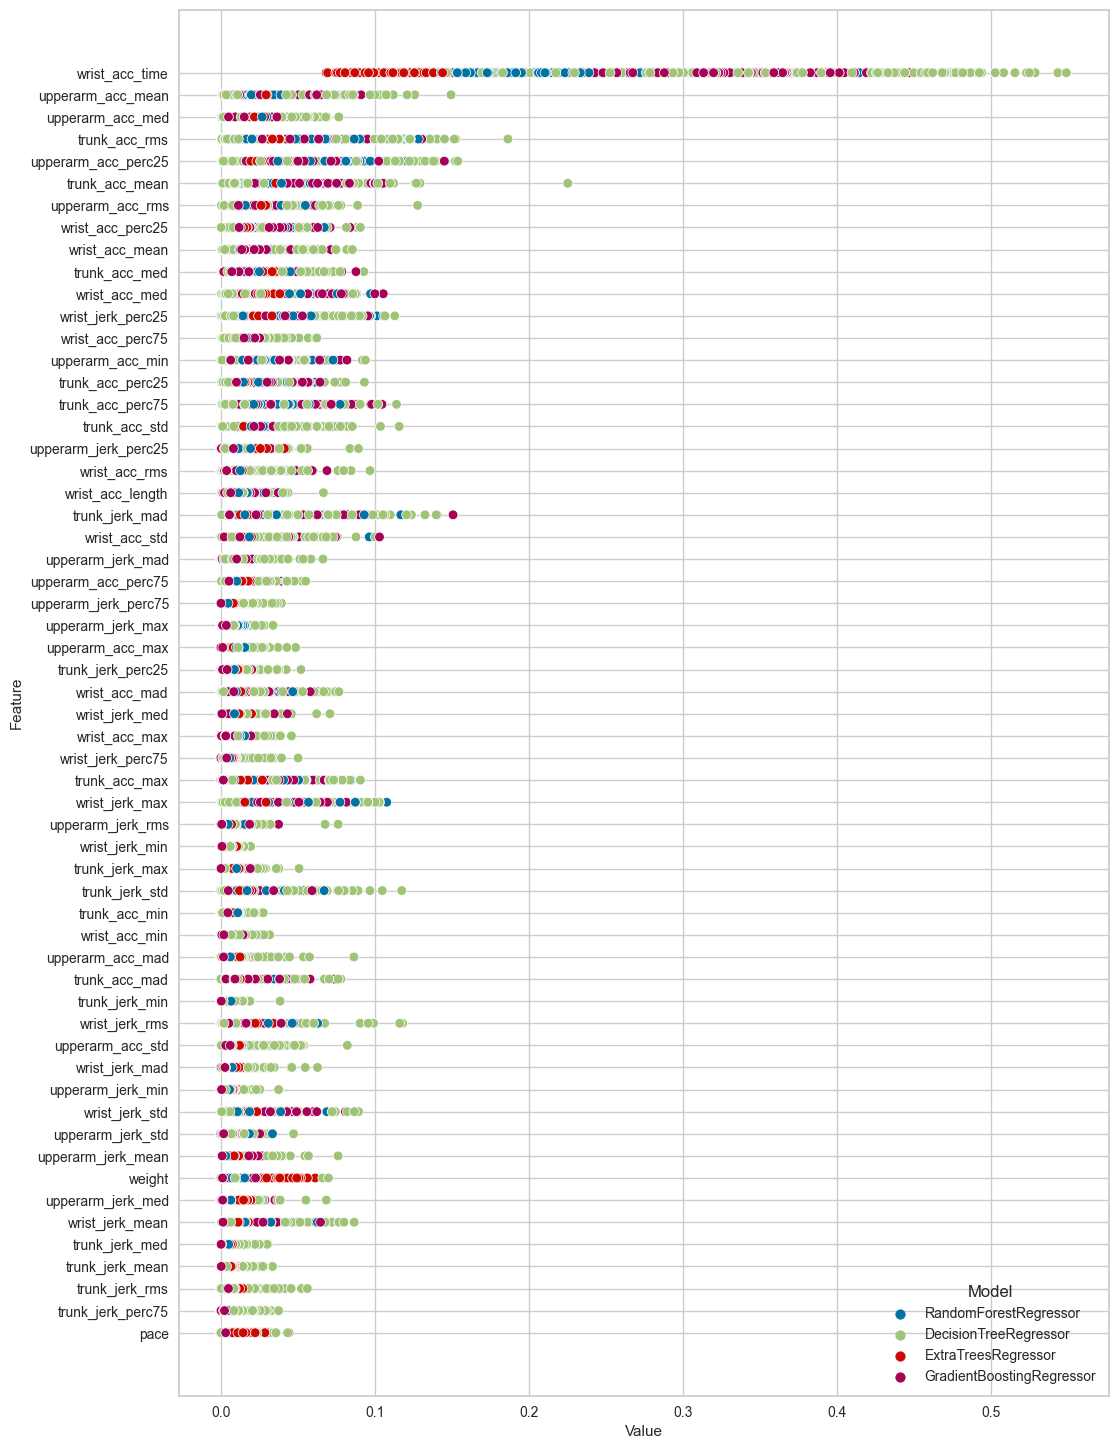

In [16]:
create_fi_plot(df_fi_g)

##### Individual Model

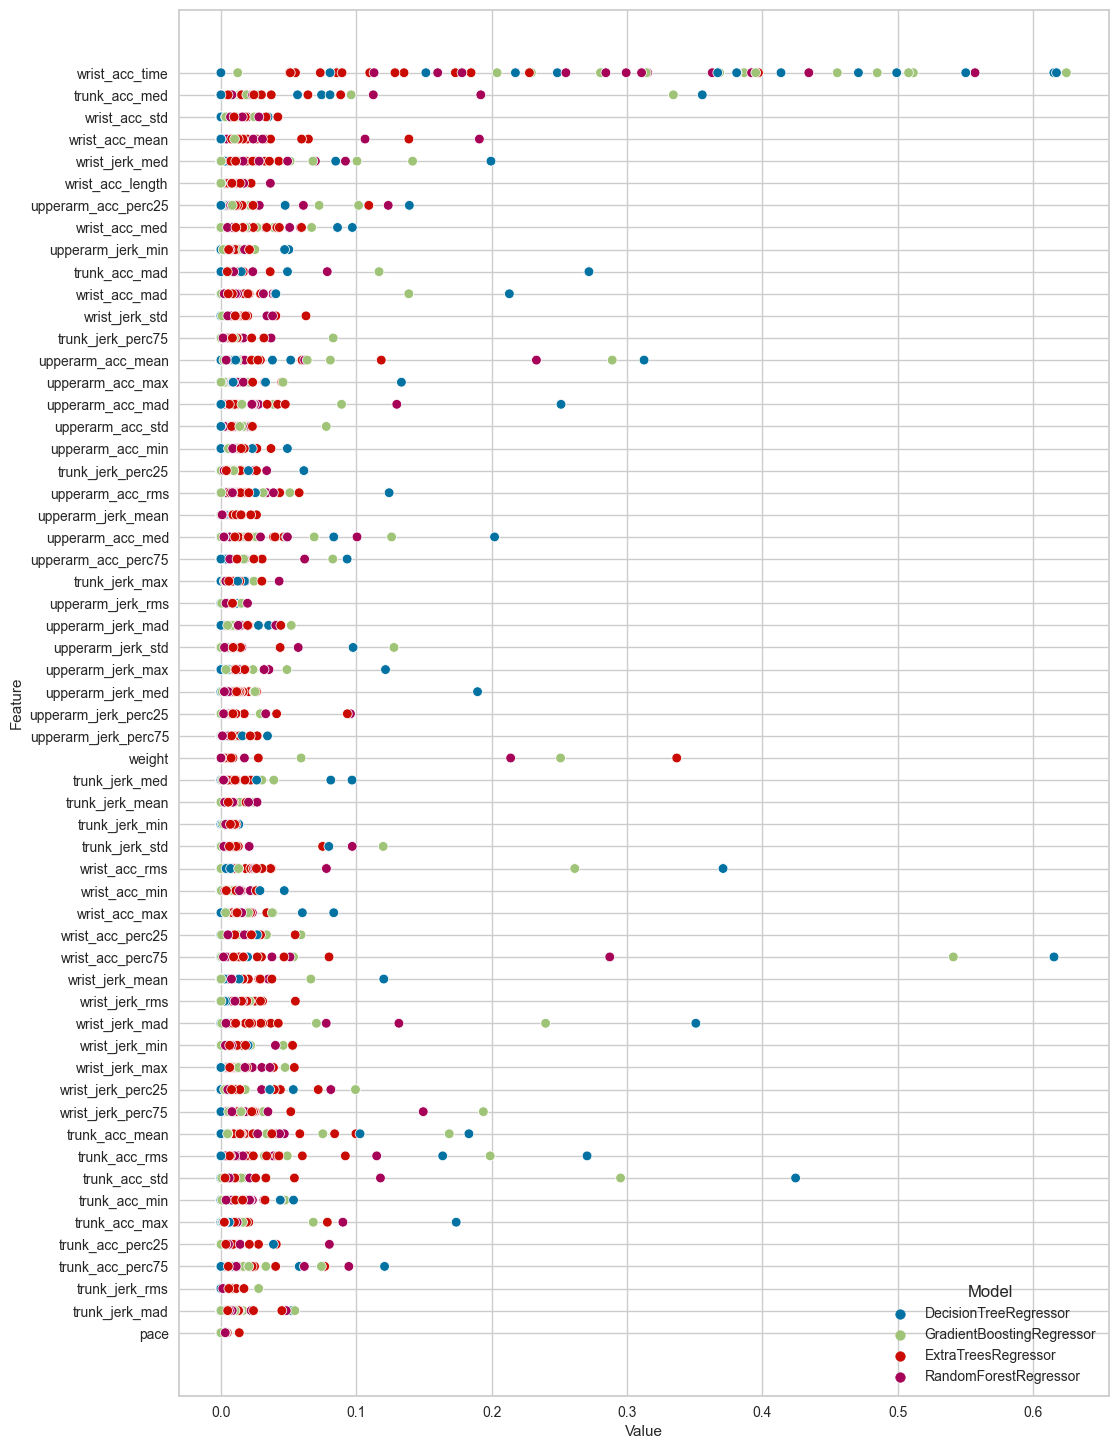

In [17]:
create_fi_plot(df_fi_i)

### Graph Function Setup

##### Data Loading and cleaning

Below is code that imports general model sensor data and modifies it appropriately

In [18]:
%%capture
# Load the appropriate data
df_t_g_s = get_data('outputs/general/sensor_test_general')
df_t_g_s = df_t_g_s[df_t_g_s['Model'] != 'Least Angle Regression']

# Below is code to order the models inside the dataframe so that they appear in a consistent order to avoid confusion.

# Calculate avg MAE values for each model
average_mae_per_model = df_t_g_s.groupby('Model')['MAE'].mean().sort_values()
sorted_models_by_mae = average_mae_per_model.index.tolist()

# Create df_t_i_s_sorted which is sorted by the model order above
df_t_g_s_sorted = df_t_g_s.copy()
df_t_g_s_sorted['Model'] = pd.Categorical(df_t_g_s_sorted['Model'], categories=sorted_models_by_mae, ordered=True)
df_t_g_s_sorted = df_t_g_s_sorted.sort_values('Model')

Below is code that imports individual model sensor data and modifies it appropriately

In [19]:
%%capture
df_t_i_s = get_data('outputs/individual/sensor_test_individual')
df_t_i_s = df_t_i_s[df_t_i_s['Model'] != 'Least Angle Regression']

# Below is code to order the models inside the dataframe so that they appear in a consistent order to avoid confusion.

# Calculate avg MAE values for each model
average_mae_per_model = df_t_i_s.groupby('Model')['MAE'].mean().sort_values()
sorted_models_by_mae = average_mae_per_model.index.tolist()

# Create df_t_i_s_sorted which is sorted by the model order above
df_t_i_s_sorted = df_t_i_s.copy()
df_t_i_s_sorted['Model'] = pd.Categorical(df_t_i_s_sorted['Model'], categories=sorted_models_by_mae, ordered=True)
df_t_i_s_sorted = df_t_i_s_sorted.sort_values('Model')

##### Boxplot function
This function creates a styled and detailed boxplot.

In [20]:
%matplotlib ipympl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches

def create_boxplot(df:DataFrame, type:str):
    # Create a figure and an Axes object
    fig, ax = plt.subplots(figsize=(14, 8))

    # Use the Axes object `ax` for the main plots
    g = sns.boxplot(x='MAE', y='Model', data=df, ax=ax, zorder=1, color="white", showfliers=False)
    sns.stripplot(x='MAE', y='Model', data=df, ax=ax, zorder=2, color='#1d95db', size=2, jitter=False, alpha=1)

    plt.subplots_adjust(left=0.18)

    top_six_models = df.groupby('Model').median().nsmallest(6, 'MAE').reset_index()['Model'].unique()
    df_mini = df[df['Model'].isin(top_six_models)]
    axins = inset_axes(ax, width="40%", height="55%", loc='upper right')

    abbreviations = {
        "K Neighbors Regressor": "KNN",
        "Random Forest Regressor":"RF",
        "Decision Tree Regressor":"DT",
        "Light Gradient Boosting Machine":"LGBM",
        "Extra Trees Regressor":"ET",
        "Gradient Boosting Regressor":"GB",
        "AdaBoost Regressor":"ADA"
    }

    df_mini = df_mini[df_mini['Model'].isin(top_six_models)].replace(abbreviations)

    sns.boxplot(x='MAE', y='Model', data=df_mini, ax=axins, zorder=1, color="white", showfliers=False).set_title('Top Six Models')
    sns.stripplot(x='MAE', y='Model', data=df_mini, ax=axins, zorder=2, color='#1d95db', size=2, jitter=False, alpha=1)

    for model in df_mini['Model'].unique():
        subset = df_mini[df_mini['Model'] == model]
        median = subset['MAE'].median()
        Q1 = subset['MAE'].quantile(0.25)
        Q3 = subset['MAE'].quantile(0.75)

        plt.scatter(median, model, color='#142a99', marker='D', s=20, zorder=3)
        plt.scatter(Q1,     model, color='#142a99', marker='s', s=15, zorder=3)
        plt.scatter(Q3,     model, color='#142a99', marker='s', s=15, zorder=3)

        padding = 0.03
        plt.text(median, model, f'{median:.2f}', size=10, color='black', verticalalignment='bottom', horizontalalignment='center')
        plt.text(Q1 - padding, model, f'{Q1:.2f}', size=10, color='black', verticalalignment='top', horizontalalignment='right')
        plt.text(Q3 + padding, model, f'{Q3:.2f}', size=10, color='black', verticalalignment='top', horizontalalignment='left')

    # Remove grid lines
    ax.grid(False)
    axins.grid(False)

    # Draw rectangle
    yticks = ax.get_yticks()
    rect_width = df_mini['MAE'].max() + 0.2  # Gets the max MAE value and adds padding
    rect_height = yticks[0] - yticks[5] - 0.8  # top y-tick - 6th (bottom) y-tick + padding
    # Specifies the starting point of the bottom left corner
    x_start = 0
    y_start = yticks[5] + 0.4
    rect = patches.Rectangle((x_start, y_start), rect_width, rect_height, linewidth=1.5, edgecolor='black', facecolor='none')
    ax.add_patch(rect)

    if type == "individual":
        plt.savefig(f'outputs/graphs/i/box_i.png')
    else:
        plt.savefig(f'outputs/graphs/g/box_g.png')


### Graphs (All), General

The graphs are all saved into the `outputs/graphs/g` directory. The output for the graphs are hidden. To view them, remove `%%capture` from the beginning of the code block.

##### Box Plot

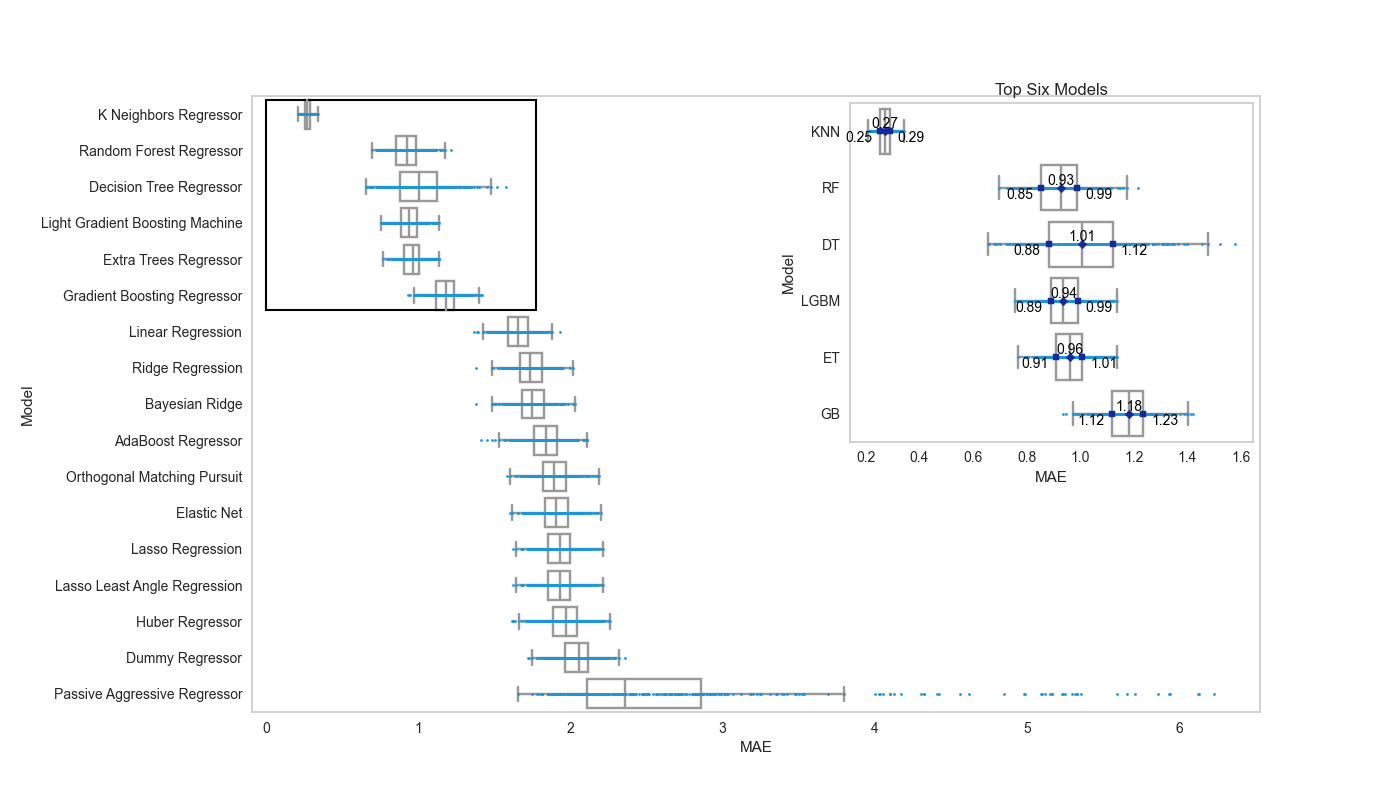

In [21]:
create_boxplot(df_t_g, "general")

##### Scatter Plot

In [22]:
%%capture
fig, ax = plt.subplots(figsize=(12, 6))
plt.subplots_adjust(left=0.18)

g = sns.scatterplot(data=df_t_g, x='MAE', y='Model', hue='MAE', palette='coolwarm')

# Determine the three quantiles to display on graph
quantile_set = [0, 0.5, 1]

# Filter the quantiles for each sensor
quantiles = df_t_g.groupby('Model')['MAE'].quantile(quantile_set).reset_index()

# Plot the quantiles as points on the scatterplot
g.scatter(quantiles.loc[quantiles['level_1'] == quantile_set[0], 'MAE'], quantiles.loc[quantiles['level_1'] == quantile_set[0], 'Model'], color='g', marker='s')
g.scatter(quantiles.loc[quantiles['level_1'] == quantile_set[1], 'MAE'], quantiles.loc[quantiles['level_1'] == quantile_set[1], 'Model'], color='g', marker='D')
g.scatter(quantiles.loc[quantiles['level_1'] == quantile_set[2], 'MAE'], quantiles.loc[quantiles['level_1'] == quantile_set[2], 'Model'], color='g', marker='s')

plt.savefig('outputs/graphs/g/sca_g.png')

##### Violin Plot

In [23]:
%%capture
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.18)

g = sns.violinplot(x='MAE', y='Model', data=df_t_g, ax=ax, palette='coolwarm', split=True)

# Set the size and aspect ratio of the graph
g.figure.set_size_inches(12, 6)

plt.savefig('outputs/graphs/g/vio_g.png')

### Graphs (Sensors), General

The graphs are all saved into the `outputs/graphs/g_s` directory. The output for the graphs are hidden. To view them, remove `%%capture` from the beginning of the code block.

##### Box Plot

In [24]:
%%capture
g = sns.FacetGrid(df_t_g_s_sorted, row='Sensor')
g.map(sns.boxplot, 'MAE', 'Model', palette='coolwarm')

# Set the size and aspect ratio of the graph
g.figure.set_size_inches(12, 18)

g.fig.tight_layout()

plt.savefig('outputs/graphs/g_s/box_g_s.png')

##### Scatter Plot

In [25]:
%%capture
g = sns.FacetGrid(df_t_g_s_sorted, row='Sensor')
g.map(sns.scatterplot, 'MAE', 'Model', palette='coolwarm')

# Determine the three quantiles to display on graph
quantile_set = [0, 0.5, 1]

# Iterate through graphs and add quantiles
for ax, sensor in zip(g.axes.flat, g.row_names):
    # Filter the quantiles for the corresponding sensor
    quantiles = df_t_g_s[df_t_g_s['Sensor'] == sensor].groupby('Model')['MAE'].quantile(quantile_set).reset_index()
    # Plot the quantiles as points on the scatterplot
    ax.scatter(quantiles.loc[quantiles['level_1'] == quantile_set[0], 'MAE'], quantiles.loc[quantiles['level_1'] == quantile_set[0], 'Model'], color='g', marker='s')
    ax.scatter(quantiles.loc[quantiles['level_1'] == quantile_set[1], 'MAE'], quantiles.loc[quantiles['level_1'] == quantile_set[1], 'Model'], color='g', marker='D')
    ax.scatter(quantiles.loc[quantiles['level_1'] == quantile_set[2], 'MAE'], quantiles.loc[quantiles['level_1'] == quantile_set[2], 'Model'], color='g', marker='s')

# Set the size and aspect ratio of the graph
g.figure.set_size_inches(12, 18)

g.fig.tight_layout()

plt.savefig('outputs/graphs/g_s/sca_g_s.png')

##### Violin Plot

In [26]:
%%capture
g = sns.FacetGrid(df_t_g_s_sorted, row='Sensor')
g.map(sns.violinplot, 'MAE', 'Model', palette='coolwarm', split=True)

# Set the size and aspect ratio of the graph
g.figure.set_size_inches(12, 18)

g.fig.tight_layout()

plt.savefig('outputs/graphs/g_s/vio_g_s.png')

### Graphs (All), Individual

The graphs are all saved into the `outputs/graphs/i` directory.

##### Box Plot

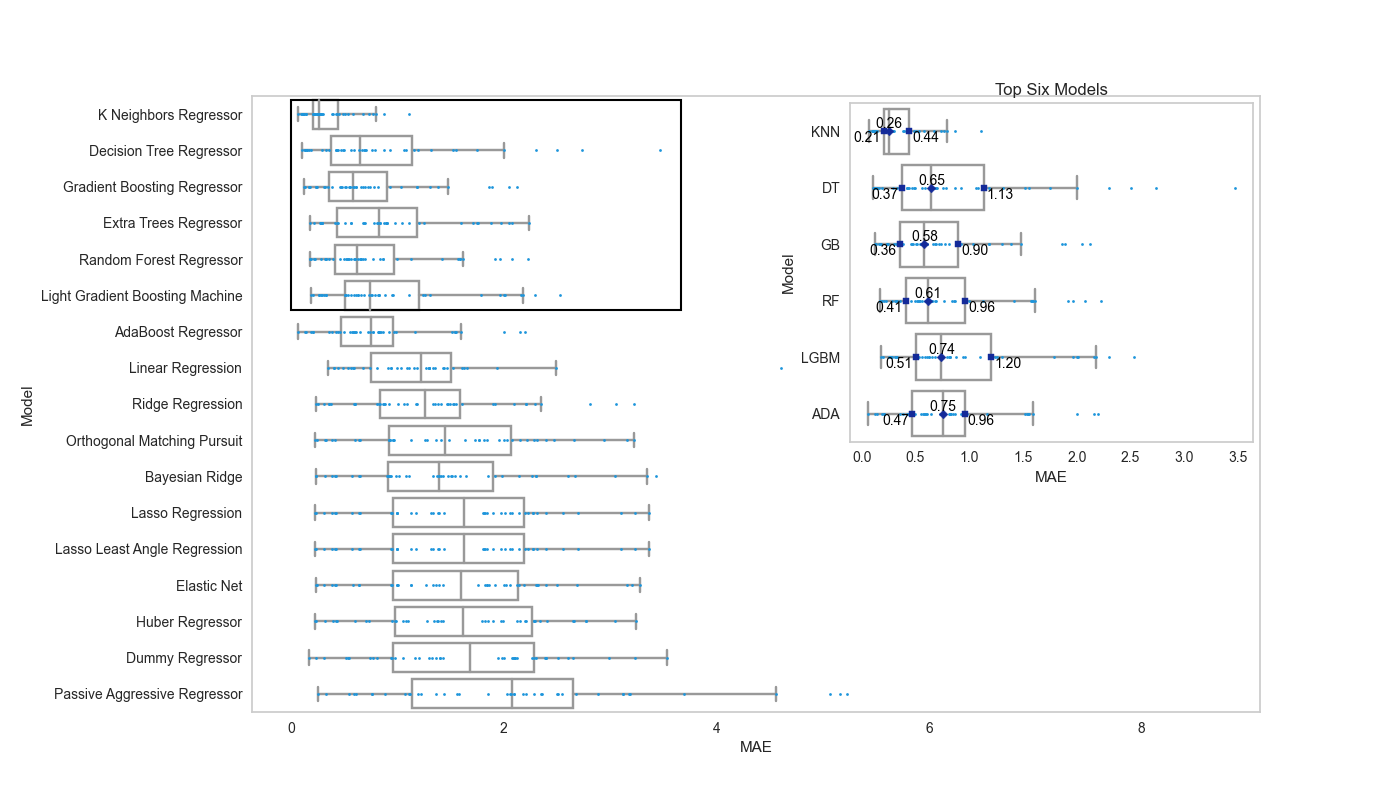

In [27]:
create_boxplot(df_t_i, "individual")

##### Scatter Plot

In [28]:
%%capture
fig, ax = plt.subplots(figsize=(12, 6))
g = sns.scatterplot(data=df_t_i, x='MAE', y='Model', hue='MAE', palette='coolwarm')
plt.subplots_adjust(left=0.18)

# Determine the three quantiles to display on graph
quantile_set = [0, 0.5, 1]

# Filter the quantiles for each sensor
quantiles = df_t_i.groupby('Model')['MAE'].quantile(quantile_set).reset_index()

# Plot the quantiles as points on the scatterplot
g.scatter(quantiles.loc[quantiles['level_1'] == quantile_set[0], 'MAE'], quantiles.loc[quantiles['level_1'] == quantile_set[0], 'Model'], color='g', marker='s')
g.scatter(quantiles.loc[quantiles['level_1'] == quantile_set[1], 'MAE'], quantiles.loc[quantiles['level_1'] == quantile_set[1], 'Model'], color='g', marker='D')
g.scatter(quantiles.loc[quantiles['level_1'] == quantile_set[2], 'MAE'], quantiles.loc[quantiles['level_1'] == quantile_set[2], 'Model'], color='g', marker='s')

plt.savefig('outputs/graphs/i/sca_i.png')

##### Violin Plot

In [29]:
%%capture
fig, ax = plt.subplots()
g = sns.violinplot(x='MAE', y='Model', data=df_t_i, ax=ax, pallete='coolwarm', split=True)
plt.subplots_adjust(left=0.18)

# Set the size and aspect ratio of the graph
g.figure.set_size_inches(12, 6)

plt.savefig('outputs/graphs/i/vio_i.png')

### Graphs (Sensor), Individual

The graphs are all saved into the `outputs/graphs/i_s` directory.

##### Box Plot

In [30]:
%%capture


g = sns.FacetGrid(df_t_i_s_sorted, row='Sensor')
g.map(sns.boxplot, 'MAE', 'Model', palette='coolwarm')

# Set the size and aspect ratio of the graph
g.figure.set_size_inches(12, 18)

g.fig.tight_layout()

plt.savefig('outputs/graphs/i_s/box_i_s.png')

##### Scatter Plot

In [31]:
%%capture
g = sns.FacetGrid(df_t_i_s_sorted, row='Sensor')
g.map(sns.scatterplot, 'MAE', 'Model', palette='coolwarm')

# Determine the three quantiles to display on graph
quantile_set = [0, 0.5, 1]

# Iterate through graphs and add quantiles
for ax, sensor in zip(g.axes.flat, g.row_names):
    # Filter the quantiles for the corresponding sensor
    quantiles = df_t_i_s[df_t_i_s['Sensor'] == sensor].groupby('Model')['MAE'].quantile(quantile_set).reset_index()
    # Plot the quantiles as points on the scatterplot
    ax.scatter(quantiles.loc[quantiles['level_1'] == quantile_set[0], 'MAE'], quantiles.loc[quantiles['level_1'] == quantile_set[0], 'Model'], color='g', marker='s')
    ax.scatter(quantiles.loc[quantiles['level_1'] == quantile_set[1], 'MAE'], quantiles.loc[quantiles['level_1'] == quantile_set[1], 'Model'], color='g', marker='D')
    ax.scatter(quantiles.loc[quantiles['level_1'] == quantile_set[2], 'MAE'], quantiles.loc[quantiles['level_1'] == quantile_set[2], 'Model'], color='g', marker='s')

# Set the size and aspect ratio of the graph
g.figure.set_size_inches(12, 18)

g.fig.tight_layout()

plt.savefig('outputs/graphs/i_s/sca_i_s.png')

##### Violin Plot

In [32]:
%%capture
g = sns.FacetGrid(df_t_i_s_sorted, row='Sensor')
g.map(sns.violinplot, 'MAE', 'Model', palette='coolwarm', split=True)

# Set the size and aspect ratio of the graph
g.figure.set_size_inches(12, 18)

g.fig.tight_layout()

plt.savefig('outputs/graphs/i_s/vio_i_s.png')

### Summary Tables

#### Summary of General Models

The table below summarizes the MAE and model results for the subject using the General models. This table has 14 rows (one for each subject), and columns for the best performing model, best achieved MAE value, median MAE value, worst MAE value, and the other subjects that were used with the subject (this is because in the General models, subjects were placed into training datasets in groups of three) when the best MAE value was obtained.

In [39]:
subjects = set()
for subjects_tuple in df_t_g['Training Subjects']:
    subjects.update(eval(subjects_tuple))

sensors = list(df_t_g_s['Sensor'].unique())

In [34]:
# Create the dataframe
df_summary_general = DataFrame(columns=['Best Model', 'Min MAE', 'Median MAE', 'Max MAE', 'Other Participants'])

for subject in subjects:
    # Filter the dataframe for rows where the current subject is in the 'Training Subjects' tuple
    subject_df = df_t_g[df_t_g['Training Subjects'].apply(lambda x: subject in eval(x))]

    # Find the model with the minimum MAE for the current subject
    best_model_row = subject_df.loc[subject_df['MAE'].idxmin()]
    best_model = best_model_row['Model']

    # Find the min MAE for the current subject
    min_mae = best_model_row['MAE']

    # Find the median MAE for the current subject
    median_mae = subject_df['MAE'].median()

    # Find the max MAE for the current subject
    max_mae = subject_df.loc[subject_df['MAE'].idxmax()]['MAE']

    # Find the 'Other Participants' in the best model scenario
    best_training_subjects = eval(best_model_row['Training Subjects'])
    other_participants = tuple(set(best_training_subjects) - {subject})

    # Update the dataframe for the current subject
    df_summary_general.loc[subject] = [best_model, min_mae, median_mae, max_mae, other_participants]

df_summary_general.sort_index(inplace=True)
df_summary_general.to_csv('outputs/summary/summary_general.csv', mode='w', header=True, index=True)

#### Summary of Individual Models

The table below summarizes the MAE and model results for the subject using the Individual models. This table has 14 rows (one for each subject), and columns for the best performing model, best achieved MAE value, median MAE value, and worst MAE value.

In [35]:
# Create the dataframe
df_summary_individual = DataFrame(columns=['Best Model', 'Min MAE', 'Median MAE', 'Max MAE'])

for subject in subjects:
    # Filter the dataframe for rows where the current subject is in the 'Training Subjects' tuple
    subject_df = df_t_i[df_t_i['Subject'] == subject]

    # Find the model with the minimum MAE for the current subject
    best_model_row = subject_df.loc[subject_df['MAE'].idxmin()]
    best_model = best_model_row['Model']

    # Find the min MAE for the current subject
    min_mae = best_model_row['MAE']

    # Find the median MAE for the current subject
    median_mae = subject_df['MAE'].median()

    # Find the max MAE for the current subject
    max_mae = subject_df.loc[subject_df['MAE'].idxmax()]['MAE']

    # Update the dataframe for the current subject
    df_summary_individual.loc[subject] = [best_model, min_mae, median_mae, max_mae]

df_summary_individual.sort_index(inplace=True)
df_summary_individual.to_csv('outputs/summary/summary_individual.csv', mode='w', header=True, index=True)

#### Summary of General Models by Sensor

In [46]:
# Assuming 'subjects' and 'sensors' are predefined lists
df_summary_general_sensor = DataFrame(columns=['Best Model', 'Min MAE', 'Median MAE', 'Max MAE', 'Other Participants', 'Sensor'])

# We'll collect data in a list before creating the DataFrame
data = []

for subject in subjects:
    for sensor in sensors:
        # Filter the dataframe for rows where the current subject is in the 'Training Subjects' tuple and by sensor
        subject_sensor_df = df_t_g_s[(df_t_g_s['Training Subjects'].apply(lambda x: subject in eval(x))) & (df_t_g_s['Sensor'] == sensor)]

        # Continue only if the dataframe is not empty
        if not subject_sensor_df.empty:
            # Find the model with the minimum MAE for the current subject and sensor
            best_model_row = subject_sensor_df.loc[subject_sensor_df['MAE'].idxmin()]
            best_model = best_model_row['Model']

            # Find min MAE
            min_mae = best_model_row['MAE']

            # Find median MAE
            median_mae = subject_sensor_df['MAE'].median()

            # Find max MAE
            max_mae = subject_sensor_df.loc[subject_sensor_df['MAE'].idxmax()]['MAE']

            # Find the 'Other Participants' in best model scenario
            best_training_subjects = eval(best_model_row['Training Subjects'])
            other_participants = tuple(set(best_training_subjects) - {subject})

            # Append gathered information
            data.append((subject, sensor, best_model, min_mae, median_mae, max_mae, other_participants))

# Create DataFrame from the data list
df_summary_general_sensor = DataFrame(data, columns=['Subject', 'Sensor', 'Best Model', 'Min MAE', 'Median MAE', 'Max MAE', 'Other Participants'])

# Set 'Subject' and 'Sensor' as the index
df_summary_general_sensor.set_index(['Subject', 'Sensor'], inplace=True)

# Sorting and saving the dataframe (sorting by index here)
df_summary_general_sensor.sort_index(inplace=True)
df_summary_general_sensor = df_summary_general_sensor.reset_index()
df_summary_general_sensor.to_csv('outputs/summary/summary_general_sensor.csv', mode='w', header=True, index=False)

#### Individual of General Models by Sensor

In [ ]:
# Assuming 'subjects' and 'sensors' are predefined lists
df_summary_individual_sensor = DataFrame(columns=['Subject', 'Sensor', 'Best Model', 'Min MAE', 'Median MAE', 'Max MAE'])

data = []

for subject in subjects:
    for sensor in sensors:
        # Correctly filter the dataframe for rows where the current subject and sensor match
        subject_sensor_df = df_t_i_s[(df_t_i_s['Subject'] == subject) & (df_t_i_s['Sensor'] == sensor)]

        # Proceed only if the filtered DataFrame is not empty
        if not subject_sensor_df.empty:
            # Correctly find the model with the minimum MAE for the current subject and sensor
            best_model_row = subject_sensor_df.loc[subject_sensor_df['MAE'].idxmin()]
            best_model = best_model_row['Model']

            # Find the min MAE for the current subject and sensor
            min_mae = best_model_row['MAE']

            # Find the median MAE for the current subject and sensor
            median_mae = subject_sensor_df['MAE'].median()

            # Find the max MAE for the current subject and sensor
            max_mae = subject_sensor_df['MAE'].max()

            # Append the gathered information to the data list
            data.append((subject, sensor, best_model, min_mae, median_mae, max_mae))

df_summary_individual_sensor = DataFrame(data, columns=['Subject', 'Sensor', 'Best Model', 'Min MAE', 'Median MAE', 'Max MAE'])

df_summary_individual_sensor.set_index(['Subject', 'Sensor'], inplace=True)
df_summary_individual_sensor = df_summary_individual_sensor.reset_index()
df_summary_individual_sensor.to_csv('outputs/summary/summary_individual_sensor.csv', mode='w', header=True, index=False)